In [ ]:
from huggingface_hub import login
login()

In [1]:
system_message = """You are a furniture expert. Analyze images and provide descriptions in this exact JSON format:
                {
                    "type": "bed, chair, table, sofa",
                    "style": "overall style",
                    "color": "main color", 
                    "material": "primary material",
                    "shape": "general shape",
                    "details": "one decorative feature",
                    "room_type": "room type",
                    "price_range": "price range in one word"
                }
                Only use the specified furniture types. Keep descriptions concise and factual."""

In [2]:
import json

def format_data(sample):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": "Describe this furniture piece in JSON format.",
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": "I will analyze the image and respond with a valid JSON object following the exact schema."}],
        },
    ]

def create_feature_dict(row):
    feature_dict = {
        'type': row['type'],
        'style': row['style'],
        'color': row['color'],
        'material': row['material'],
        'shape': row['shape'],
        'details': row['details'],
        'room_type': row['room_type'],
        'price_range': row['price_range']
    }
    # Convert dictionary to string
    return json.dumps(feature_dict)

In [4]:
from datasets import load_dataset

ds = load_dataset("filnow/furniture-synthetic-dataset")

train_dataset = ds['train']

json_features = [create_feature_dict(item) for item in train_dataset]

# Add new feature to dataset
train_dataset = train_dataset.add_column("features_json", json_features)

In [5]:
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

model_id = "Qwen/Qwen2-VL-2B-Instruct"

model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

# Apply PEFT model adaptation

peft_model = get_peft_model(model, peft_config)

# Print trainable parameters

peft_model.print_trainable_parameters()

trainable params: 1,089,536 || all params: 2,210,075,136 || trainable%: 0.0493


In [5]:
from qwen_vl_utils import process_vision_info

def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [
        processor.apply_chat_template(example, tokenize=False) for example in examples
    ]  # Prepare texts for processing
    image_inputs = [process_vision_info(example)[0] for example in examples]  # Process the images to extract inputs

    # Tokenize the texts and process the images
    batch = processor(
        text=texts, images=image_inputs, return_tensors="pt", padding=True
    )  # Encode texts and images into tensors

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()  # Clone input IDs for labels
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels

    # Ignore the image token index in the loss computation (model specific)
    if isinstance(processor, Qwen2VLProcessor):  # Check if the processor is Qwen2VLProcessor
        image_tokens = [151652, 151653, 151655]  # Specific image token IDs for Qwen2VLProcessor
    else:
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]  # Convert image token to ID

    # Mask image token IDs in the labels
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    labels = [ex["features_json"] for ex in examples]
    batch["labels"] = labels

    return batch  # Return the prepared batch

In [3]:
import json
from datasets import load_dataset
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from peft import LoraConfig, get_peft_model
from qwen_vl_utils import process_vision_info
from transformers import TrainingArguments
import os 
from transformers import Trainer


model_id = "Qwen/Qwen2-VL-2B-Instruct"

model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

adapter_path = "filnow/furniture-qwen2vl"

model.load_adapter(adapter_path)

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/721 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.37M [00:00<?, ?B/s]

In [6]:
from qwen_vl_utils import process_vision_info


def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        format_data(sample), tokenize=False, add_generation_prompt=True  # Use the sample without the system message
    )

    # Process the visual input from the sample
    image_inputs, _ = process_vision_info(format_data(sample))

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(
        device
    )  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

-------Base Model Output-------


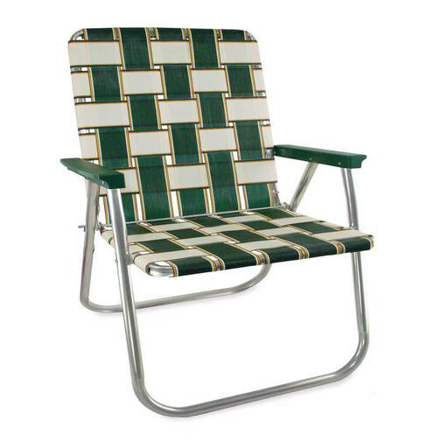

```json
{
  "type": "chair",
  "style": "outdoor",
  "color": "green and white",
  "material": "aluminum",
  "shape": "webbed",
  "details": "armrests",
  "room_type": "outdoor",
  "price_range": "cheap"
}
```


In [10]:
import json

output = generate_text_from_sample(model, processor, ds['test'][300])


print("-------Base Model Output-------")

ds['test'][300]['image'].show()

print(output)

# json_data = json.loads(output)
# print(json.dumps(json_data, indent=2))

-------LORA Output-------


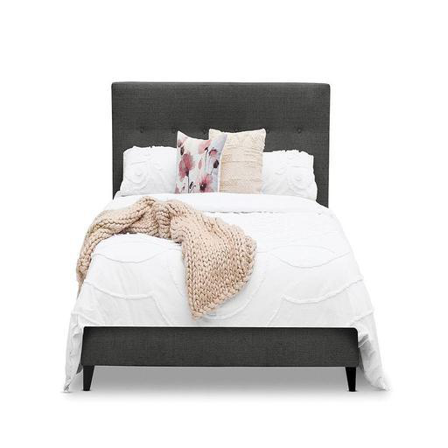

{
  "type": "bed",
  "style": "minimal",
  "color": "charcoal",
  "material": "linen",
  "shape": "tufted",
  "details": "no frame",
  "room_type": "master",
  "price_range": "premium"
}


In [15]:
import json

output = generate_text_from_sample(model, processor, ds['test'][50])


print("-------LORA Output-------")

ds['test'][50]['image'].show()

json_data = json.loads(output)
print(json.dumps(json_data, indent=2))
